In [1]:
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from shapely.geometry import Point, Polygon
import geopandas as gpd
import random

warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')


In [2]:
# firm location generation
def Random_Points_in_Polygon(polygon, number):
    points = []
    temp = polygon.bounds
    counter = 0
#     print(minx, miny, maxx, maxy)
    while counter < number:
        pnt = Point(random.uniform(temp.minx.values[0], temp.maxx.values[0]), random.uniform(temp.miny, temp.maxy.values[0]))
#         print(pnt.within(polygon))
#         print(pnt)
#         print(polygon)
        if polygon.contains(pnt).all():
            points.append(pnt)
            counter += 1
    return points

In [3]:
# vehicle assignment function
def veh_type_simulator(n_truck, vehicle_type_fraction): # Simulate mode choice
    choice = np.random.multinomial(n_truck, vehicle_type_fraction, size = 1)
    choice = pd.Series(choice[0])
#     print(choice)
    return(choice)

def split_dataframe(df, chunk_size = 100000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [4]:
# generate firm location
output_dir = 'outputs_aus_2050'
firm_name = 'forecasted_firms.csv'
firms = read_csv(output_dir + '/' + firm_name)
zonal_shapefile = gpd.read_file('inputs/Austin_freight.geojson')
print(zonal_shapefile.columns)

Index(['GEOID', 'CBPZONE', 'MESOZONE', 'geometry'], dtype='object')


In [ ]:
# print(firms.columns)
unique_zones = firms.MESOZONE.unique()
firms_with_location = None
for zone in unique_zones:
#     print(zone)
    firms_within_zone = firms.loc[firms['MESOZONE'] == zone]
    sample_size = len(firms_within_zone)
    zonal_polygon = \
    zonal_shapefile.loc[zonal_shapefile['MESOZONE'] == zone]
    
    points = Random_Points_in_Polygon(zonal_polygon, sample_size)
    points_df = pd.DataFrame(points, columns = ['geometry'])
    points_gdf = gpd.GeoDataFrame(points_df) 
    points_gdf.loc[:, 'lat'] = points_gdf.geometry.y
    points_gdf.loc[:, 'lon'] = points_gdf.geometry.x
    points_out = pd.DataFrame(points_gdf.drop(columns='geometry'))
    firms_within_zone = pd.concat([firms_within_zone.reset_index(), 
                                   points_out.reset_index()], 
                                  axis = 1)
    firms_with_location = pd.concat([firms_with_location, firms_within_zone])
#     break
firms_with_location.to_csv(output_dir + '/forecasted_firms_with_location.csv', index = False)
firms_with_location.head(5)

In [ ]:
print(len(firms.BusID.unique()))
print(len(firms))
points_df = pd.DataFrame(points, columns = ['geometry'])
# points_df.to_csv(output_dir + '/points_troubleshoot.csv')
points_gdf = gpd.GeoDataFrame(points_df)  
# lat = points_gdf.geometry.y
# lon = points_gdf.geometry.x
# print(lat)
base = zonal_polygon.boundary.plot(linewidth=1, edgecolor="black")
points_gdf.plot(ax=base, linewidth=1, color="red", alpha = 0.1, markersize=0.5)
plt.show()
# xp,yp = zonal_polygon.exterior.xy
# plt.plot(xp,yp)

# # Plot the list of points
# xs = [point.x for point in points]
# ys = [point.y for point in points]
# plt.scatter(xs, ys,color="red")
# plt.show()

In [4]:
scenario_name = 'TDA_low'
input_dir = 'outputs_aus_2050/'
output_dir = 'outputs_aus_2050'
firm_name = 'forecast_firms_with_location.csv'
firms = read_csv(input_dir + '/' + firm_name)
private_fleet = read_csv('inputs/fleet/TX_private_fleet_size_distribution_V2.csv')
for_hire_fleet = read_csv('inputs/fleet/TX_for_hire_fleet_size_distribution_V2.csv')
for_lease_fleet = read_csv('inputs/fleet/TX_for_lease_fleet_size_distribution_V2.csv')
cargo_type_distribution = read_csv("inputs/fleet/probability_of_cargo_group.csv")

# forecast values
national_fleet_composition = read_csv('inputs/fleet/' + scenario_name + '/TDA_vehicle_stock.csv')
vehicle_type_by_state = read_csv('inputs/fleet/' + scenario_name + '/fleet_composition_by_state.csv')
# ev_fraction = read_csv('inputs/fleet/' + scenario_name + '/EV_fraction_by_type.csv')
ev_availability = read_csv('inputs/fleet/' + scenario_name + '/EV_availability.csv')

state_fips_lookup = read_csv('inputs/us-state-ansi-fips.csv')
# vehicle_type_fraction = [0.206287,	0.505178, 0.244464, 0.044071]  # will be replaced once input from Alicia is ready

In [5]:
# filter vehicle composition data
analysis_year = 2018
vehicle_type_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Year'] == analysis_year]

national_fleet_composition = \
national_fleet_composition.loc[national_fleet_composition['Year'] == analysis_year]

# ev_fraction = ev_fraction.loc[ev_fraction['Year'] == analysis_year]

ev_availability = ev_availability.loc[ev_availability['Year'] == analysis_year]

ev_availability.head(5)

,Year,vehicle type,Powertrain,Stock,EV_fraction
0,2018,Class 4-6 Vocational,Battery Electric,101.0,1.0
1,2018,Class 4-6 Vocational,H2 Fuel Cell,0.0,0.0
2,2018,Class 4-6 Vocational,PHEV Diesel,0.0,0.0
3,2018,Class 4-6 Vocational,PHEV Gasoline,0.0,0.0
4,2018,Class 7&8 Tractor,Battery Electric,6.0,1.0


In [7]:
# format fleet composition
list_of_veh_tech = vehicle_type_by_state['vehicle category'].unique().tolist()

private_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'PRIVATE']
private_fleet_by_state_wide = pd.pivot_table(private_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
private_fleet_by_state_wide = private_fleet_by_state_wide.reset_index()


for_hire_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'FOR HIRE']
for_hire_fleet_by_state_wide = pd.pivot_table(for_hire_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_hire_fleet_by_state_wide = for_hire_fleet_by_state_wide.reset_index()


for_lease_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'LEASE']
for_lease_fleet_by_state_wide = pd.pivot_table(for_lease_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_lease_fleet_by_state_wide = for_lease_fleet_by_state_wide.reset_index()

private_fleet_by_state_wide.head(5)

vehicle category,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,ALABAMA,0.243046,0.303801,0.282828,0.000012,6.467405e-07,2.889022e-07,0.169764
1,ALASKA,0.275343,0.221711,0.309854,0.000014,4.719849e-07,3.165081e-07,0.192323
2,ARIZONA,0.274482,0.308356,0.224665,0.000013,6.564382e-07,2.294897e-07,0.191722
3,ARKANSAS,0.158329,0.538997,0.191483,0.000008,1.147434e-06,1.955959e-07,0.110591
4,CALIFORNIA,0.279156,0.327610,0.197732,0.000014,6.974263e-07,2.019784e-07,0.194987


8461670
8461670


,fleet_size,min_size,fraction_of_carrier,avg_truck_per_carrier,total_truck_std,n_trucks
0,0-2,1,0.709745,1.218434,0.413643,1
0,0-2,1,0.709745,1.218434,0.413643,1
0,0-2,1,0.709745,1.218434,0.413643,1
1,3-5,3,0.154389,3.692529,0.778908,3
1,3-5,3,0.154389,3.692529,0.778908,3


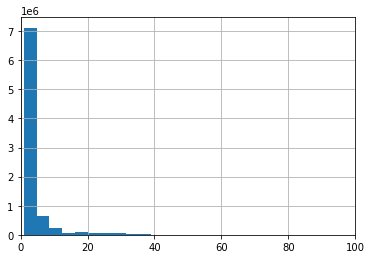

In [8]:
sample_size = len(firms)
print(sample_size)
# print(tx_private_fleet.columns)
private_fleet_short = private_fleet[['fleet_size', 'min_size', 
                                    'fraction_of_carrier', 
                                    'avg_truck_per_carrier', 
                                    'total_truck_std']]

firm_fleet_sample = \
private_fleet_short.sample(n = sample_size,
                           weights = private_fleet_short['fraction_of_carrier'],
                           replace = True)
print(len(firm_fleet_sample))
# generate random fleet size
firm_fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = firm_fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = firm_fleet_sample.loc[:, 'total_truck_std'])
criteria = (firm_fleet_sample['n_trucks'] <= firm_fleet_sample['min_size'])
firm_fleet_sample.loc[criteria, 'n_trucks'] = firm_fleet_sample.loc[criteria, 'min_size']
firm_fleet_sample.loc[:, 'n_trucks'] = np.round(firm_fleet_sample.loc[:, 'n_trucks'], 0)
firm_fleet_sample.loc[:, 'n_trucks'] = firm_fleet_sample.loc[:, 'n_trucks'].astype(int)

firm_fleet_sample['n_trucks'].hist(bins = 1000)
plt.xlim([0,100])
firm_fleet_sample.head(5)

In [9]:
# append vehicle composition to firms by state
firm_fleet_sample = firm_fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
firms = firms.sort_values(by = ['Emp'], ascending = True)

firms.loc[:, 'FAFZONE'] = firms.loc[:,'FAFZONE'].astype(str).str.zfill(3)
firms.loc[:, 'st'] = firms.loc[:, 'FAFZONE'].str[:2]
firms.loc[:, 'st'] = firms.loc[:, 'st'].astype(int)

firms = pd.merge(firms, state_fips_lookup, on = 'st', how = 'left')
print(len(firms))
firms.loc[:,'stname'] = firms.loc[:,'stname'].str.upper()

firm_fleet_sample_short = firm_fleet_sample[['n_trucks']]

firms_with_fleet = pd.concat([firms.reset_index(drop=True), 
                              firm_fleet_sample_short.reset_index(drop=True)], axis=1)


firms_with_fleet = pd.merge(firms_with_fleet, private_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

firms_with_fleet.head(5)

8461670


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stusps,n_trucks,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,56,251,1,52A000,0,0.000635,3151496,20056,42.843757,-70.758827,...,MA,1,MASSACHUSETTS,0.317864,0.137498,0.322429,0.000016,2.927105e-07,3.293537e-07,0.222023
1,29,132,1,336411,37,0.001221,1099966,20029,32.263037,-81.669580,...,GA,1,GEORGIA,0.277786,0.309447,0.218503,0.000014,6.587605e-07,2.231957e-07,0.194030
2,41,190,1,335222,34,0.001437,1088473,20041,42.467350,-92.444601,...,IA,1,IOWA,0.126859,0.511540,0.272772,0.000006,1.088982e-06,2.786298e-07,0.088609
3,22,111,1,522A00,0,0.001840,3184607,20022,38.932896,-76.964109,...,DC,1,DISTRICT OF COLUMBIA,0.554441,0.009534,0.048729,0.000027,2.029602e-08,4.977529e-08,0.387269
4,22,111,1,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,...,DC,1,DISTRICT OF COLUMBIA,0.554441,0.009534,0.048729,0.000027,2.029602e-08,4.977529e-08,0.387269


In [10]:
# assign vehicle technology
print(firms_with_fleet.n_trucks.sum())
# firms_with_no_fleet = firms_with_fleet.loc[firms_with_fleet['n_trucks'] == 0]

# firms_with_fleet_1 = firms_with_fleet.loc[firms_with_fleet['n_trucks'] > 0]
chunks = split_dataframe(firms_with_fleet)
var_to_keep = ['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'n_trucks',
       'st', 'stname']

# firms_with_no_fleet = firms_with_no_fleet[var_to_keep]
# firms_with_no_fleet.loc[:, 'veh_type'] = np.nan
# firms_with_no_fleet.loc[:, 'number_of_veh'] = np.nan
# firms_with_no_fleet.loc[:, 'fleet_id'] = np.nan
i = 0
firms_with_fleet = None
for chunk in chunks:
    print('processing chunk ' + str(i))
    chunk[list_of_veh_tech] = \
    chunk.apply(
            lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
    chunk = pd.melt(chunk, id_vars = var_to_keep, 
                    value_vars = list_of_veh_tech, 
                   var_name = 'veh_type',
                   value_name = 'number_of_veh')
    chunk = chunk.reset_index()
    chunk = chunk.loc[chunk['number_of_veh'] > 0]
    chunk.loc[:, 'fleet_id']=chunk.groupby('BusID').cumcount() + 1
#     print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))
#     if i==0:
#         firms_with_fleet = chunk
#     else:
#     if len(chunk) > 0:
    firms_with_fleet = pd.concat([firms_with_fleet, chunk])
    i += 1

#     if len(chunk) > 0:
#         break
# chunk.head(5) 
print(firms_with_fleet.number_of_veh.sum())
# firms_with_fleet = pd.concat([firms_with_no_fleet, firms_with_fleet]) 
firms_with_fleet.head(5)

41871272
processing chunk 0
processing chunk 1
processing chunk 2
processing chunk 3
processing chunk 4
processing chunk 5
processing chunk 6
processing chunk 7
processing chunk 8
processing chunk 9
processing chunk 10
processing chunk 11
processing chunk 12
processing chunk 13
processing chunk 14
processing chunk 15
processing chunk 16
processing chunk 17
processing chunk 18
processing chunk 19
processing chunk 20
processing chunk 21
processing chunk 22
processing chunk 23
processing chunk 24
processing chunk 25
processing chunk 26
processing chunk 27
processing chunk 28
processing chunk 29
processing chunk 30
processing chunk 31
processing chunk 32
processing chunk 33
processing chunk 34
processing chunk 35
processing chunk 36
processing chunk 37
processing chunk 38
processing chunk 39
processing chunk 40
processing chunk 41
processing chunk 42
processing chunk 43
processing chunk 44
processing chunk 45
processing chunk 46
processing chunk 47
processing chunk 48
processing chunk 49
p

,index,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,n_trucks,st,stname,veh_type,number_of_veh,fleet_id
4,4,1,22,111,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,1,11,DISTRICT OF COLUMBIA,Diesel Class 4-6 Vocational,1,1
5,5,1,22,111,522A00,0,0.001840,3184606,20022,38.938188,-77.063106,1,11,DISTRICT OF COLUMBIA,Diesel Class 4-6 Vocational,1,1
6,6,1,79,363,52A000,0,0.002098,3033136,20079,40.793759,-73.219696,1,36,NEW YORK,Diesel Class 4-6 Vocational,1,1
17,17,1,74,341,52A000,0,0.002834,3151492,20074,40.482336,-74.867788,1,34,NEW JERSEY,Diesel Class 4-6 Vocational,1,1
19,19,1,12,064,336414,37,0.002861,1101643,20012,38.118855,-121.952656,1,6,CALIFORNIA,Diesel Class 4-6 Vocational,1,1


In [11]:
print(len(firms_with_fleet.BusID.unique()))
firms_to_check = firms_with_fleet.loc[firms_with_fleet['BusID'] == 6166948]
firms_to_check.head(8)

8461670


,index,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,n_trucks,st,stname,veh_type,number_of_veh,fleet_id
93339,93339,2,34,171,623A00,0,70.61839,6166948,20034,41.285799,-89.062478,29,17,ILLINOIS,Diesel Class 4-6 Vocational,8,1
293339,293339,2,34,171,623A00,0,70.61839,6166948,20034,41.285799,-89.062478,29,17,ILLINOIS,Gasoline Class 4-6 Vocational,3,2
393339,393339,2,34,171,623A00,0,70.61839,6166948,20034,41.285799,-89.062478,29,17,ILLINOIS,Diesel Class 7&8 Tractor,11,3
593339,593339,2,34,171,623A00,0,70.61839,6166948,20034,41.285799,-89.062478,29,17,ILLINOIS,Diesel Class 7&8 Vocational,7,4


In [12]:
# processing carriers
firms['Industry_NAICS6_Make'] = firms['Industry_NAICS6_Make'].astype(str)

new_firms = firms[['esizecat', 'CBPZONE', 'FAFZONE',
                              'Industry_NAICS6_Make', 'Commodity_SCTG',	
                              'Emp', 'BusID', 'MESOZONE', 'lat', 'lon',
                              'stname', 'st']]


carriers = new_firms.loc[new_firms['Industry_NAICS6_Make'].isin(['492000', '484000'])]
print(carriers['Industry_NAICS6_Make'].unique())
sample_size = len(carriers)
# print(tx_private_fleet.columns)
for_hire_fleet_short = for_hire_fleet[['fleet_size', 'min_size', 
                                           'fraction_of_carrier', 
                                           'avg_truck_per_carrier', 
                                           'total_truck_std']]

fleet_sample = for_hire_fleet_short.sample(n = sample_size,
                                            weights = for_hire_fleet_short['fraction_of_carrier'],
                                            replace = True)
print(len(fleet_sample))
fleet_sample.head(5)
                                                        

['492000' '484000']
159980


,fleet_size,min_size,fraction_of_carrier,avg_truck_per_carrier,total_truck_std
3,11-50,11,0.067961,20.539359,9.100769
0,0-2,1,0.676541,1.233709,0.423566
2,6-10,6,0.077274,7.462821,1.361454
0,0-2,1,0.676541,1.233709,0.423566
1,3-5,3,0.166138,3.708408,0.781045


In [13]:
var_to_keep = ['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'n_trucks',
       'st', 'stname']

fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = fleet_sample.loc[:, 'total_truck_std'])
criteria = (fleet_sample['n_trucks'] <= fleet_sample['min_size'])
fleet_sample.loc[criteria, 'n_trucks'] = fleet_sample.loc[criteria, 'min_size']
fleet_sample.loc[:, 'n_trucks'] = np.round(fleet_sample.loc[:, 'n_trucks'], 0)
fleet_sample.loc[:, 'n_trucks'] = fleet_sample.loc[:, 'n_trucks'].astype(int)
# fleet_sample.head(5)
fleet_sample = fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
carriers = carriers.sort_values(by = ['Emp'], ascending = True)

fleet_sample_short = fleet_sample[['n_trucks']]

carriers_with_fleet = pd.concat([carriers.reset_index(drop=True), 
                                 fleet_sample_short.reset_index(drop=True)], axis=1)

carriers_with_fleet = pd.merge(carriers_with_fleet, for_hire_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

carriers_with_fleet[list_of_veh_tech] = \
carriers_with_fleet.apply(
        lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
# print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))

carriers_with_fleet = pd.melt(carriers_with_fleet, id_vars = var_to_keep, 
                value_vars = list_of_veh_tech, 
               var_name = 'veh_type',
               value_name = 'number_of_veh')
carriers_with_fleet = carriers_with_fleet.reset_index()
carriers_with_fleet = carriers_with_fleet.loc[carriers_with_fleet['number_of_veh'] > 0]
carriers_with_fleet.loc[:, 'fleet_id'] = \
carriers_with_fleet.groupby('BusID').cumcount() + 1

carriers.head(5)


,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,stname,st
633,1,49,222,492000,0,0.012807,8442331,20049,29.823220,-93.721271,LOUISIANA,22
634,1,48001,489,492000,0,0.012807,2877133,6,31.781069,-95.621497,TEXAS,48
635,1,48001,489,492000,0,0.012807,2877134,35,31.630904,-95.575748,TEXAS,48
636,1,48027,489,492000,0,0.012807,2876123,373,31.108142,-97.749684,TEXAS,48
1045,1,48041,489,492000,0,0.017367,2886569,1671,30.595009,-96.325727,TEXAS,48


In [14]:
# generate fleet for vehicle leasing firms
leasing = new_firms.loc[new_firms['Industry_NAICS6_Make'].isin(['532100'])]
sample_size = len(leasing)
# print(tx_private_fleet.columns)
for_lease_fleet_short = for_lease_fleet[['fleet_size', 'min_size', 
                                           'fraction_of_carrier', 
                                           'avg_truck_per_carrier', 
                                           'total_truck_std']]

fleet_sample = for_lease_fleet_short.sample(n = sample_size,
                                            weights = for_lease_fleet_short['fraction_of_carrier'],
                                            replace = True)
print(len(fleet_sample))
fleet_sample.head(5)

fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = fleet_sample.loc[:, 'total_truck_std'])
criteria = (fleet_sample['n_trucks'] <= fleet_sample['min_size'])
fleet_sample.loc[criteria, 'n_trucks'] = fleet_sample.loc[criteria, 'min_size']
fleet_sample.loc[:, 'n_trucks'] = np.round(fleet_sample.loc[:, 'n_trucks'], 0)
fleet_sample.loc[:, 'n_trucks'] = fleet_sample.loc[:, 'n_trucks'].astype(int)
# fleet_sample.head(5)
fleet_sample = fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
leasing = leasing.sort_values(by = ['Emp'], ascending = True)

fleet_sample_short = fleet_sample[['n_trucks']]

leasing_with_fleet = pd.concat([leasing.reset_index(drop=True), 
                              fleet_sample_short.reset_index(drop=True)], axis=1)

leasing_with_fleet = pd.merge(leasing_with_fleet, for_lease_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

leasing_with_fleet[list_of_veh_tech] = \
leasing_with_fleet.apply(
        lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
# print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))
leasing_with_fleet = pd.melt(leasing_with_fleet, 
                             id_vars = var_to_keep, 
                value_vars = list_of_veh_tech, 
               var_name = 'veh_type',
               value_name = 'number_of_veh')
leasing_with_fleet = leasing_with_fleet.reset_index()
leasing_with_fleet = leasing_with_fleet.loc[leasing_with_fleet['number_of_veh'] > 0]
leasing_with_fleet.loc[:, 'fleet_id'] = leasing_with_fleet.groupby('BusID').cumcount() + 1

leasing_with_fleet.head(5)

16535


,index,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,n_trucks,st,stname,veh_type,number_of_veh,fleet_id
11,11,1,53,241,532100,0,0.038613,3849677,20053,39.425355,-77.108911,1,24,MARYLAND,Diesel Class 4-6 Vocational,1,1
12,12,1,53,241,532100,0,0.038613,3849679,20053,38.991580,-76.125182,1,24,MARYLAND,Diesel Class 4-6 Vocational,1,1
15,15,1,53,241,532100,0,0.038613,3849678,20053,39.526637,-76.148158,1,24,MARYLAND,Diesel Class 4-6 Vocational,1,1
17,17,1,87,391,532100,0,0.116653,3849913,20087,39.140527,-83.962149,1,39,OHIO,Diesel Class 4-6 Vocational,1,1
22,22,1,100,429,532100,0,0.136792,3849833,20100,39.867247,-79.986618,1,42,PENNSYLVANIA,Diesel Class 4-6 Vocational,1,1


In [15]:
print(len(leasing_with_fleet))
print(len(leasing.BusID.unique()))

31913
16535


In [16]:
# post-processing results
# firms_with_fleet['Industry_NAICS6_Make'] = firms_with_fleet['Industry_NAICS6_Make'].astype(str)
firms_with_fleet = \
firms_with_fleet[~firms_with_fleet['Industry_NAICS6_Make'].isin(['492000', '484000', '532100'])]
print(len(firms_with_fleet))
# firms_with_fleet.loc[:, list_of_veh_tech] = 1
firms_with_fleet.head(5)

14424087


,index,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,n_trucks,st,stname,veh_type,number_of_veh,fleet_id
4,4,1,22,111,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,1,11,DISTRICT OF COLUMBIA,Diesel Class 4-6 Vocational,1,1
5,5,1,22,111,522A00,0,0.001840,3184606,20022,38.938188,-77.063106,1,11,DISTRICT OF COLUMBIA,Diesel Class 4-6 Vocational,1,1
6,6,1,79,363,52A000,0,0.002098,3033136,20079,40.793759,-73.219696,1,36,NEW YORK,Diesel Class 4-6 Vocational,1,1
17,17,1,74,341,52A000,0,0.002834,3151492,20074,40.482336,-74.867788,1,34,NEW JERSEY,Diesel Class 4-6 Vocational,1,1
19,19,1,12,064,336414,37,0.002861,1101643,20012,38.118855,-121.952656,1,6,CALIFORNIA,Diesel Class 4-6 Vocational,1,1


In [17]:
# adjust the total fleet

# national_fleet_composition.head(5)
firms_with_fleet_nonzero = firms_with_fleet.dropna(subset = ['number_of_veh'])
firm_fleet_agg = firms_with_fleet_nonzero.groupby(['veh_type'])[['number_of_veh']].sum()
# firm_fleet_agg = firm_fleet_agg.to_frame()
firm_fleet_agg = firm_fleet_agg.reset_index()
firm_fleet_agg.columns = ['vehicle_type', 'total']
firm_fleet_agg.loc[:, 'source'] = 'firms'


carrier_fleet_agg = carriers_with_fleet.groupby(['veh_type'])[['number_of_veh']].sum()
# carrier_fleet_agg = carrier_fleet_agg.to_frame()
carrier_fleet_agg = carrier_fleet_agg.reset_index()
carrier_fleet_agg.columns = ['vehicle_type', 'total']
carrier_fleet_agg.loc[:, 'source'] = 'carrier'

lease_fleet_agg = leasing_with_fleet.groupby(['veh_type'])[['number_of_veh']].sum()
# lease_fleet_agg = lease_fleet_agg.to_frame()
lease_fleet_agg = lease_fleet_agg.reset_index()
lease_fleet_agg.columns = ['vehicle_type', 'total']
lease_fleet_agg.loc[:, 'source'] = 'lease'

modeled_fleet_agg = pd.concat([firm_fleet_agg, carrier_fleet_agg, lease_fleet_agg])
modeled_fleet_agg.head(5)

,vehicle_type,total,source
0,Diesel Class 4-6 Vocational,10533778,firms
1,Diesel Class 7&8 Tractor,12448474,firms
2,Diesel Class 7&8 Vocational,10907457,firms
3,Electric Class 4-6 Vocational,510,firms
4,Electric Class 7&8 Tractor,24,firms


In [18]:
# calculate the scaling factor
total_modeled_veh = pd.pivot_table(modeled_fleet_agg, values='total', 
                                   index=['vehicle_type'], columns=['source'], aggfunc=np.sum)
total_modeled_veh = total_modeled_veh.reset_index()
# total_modeled_veh.head(5)

total_modeled_veh = total_modeled_veh.reset_index()
print(national_fleet_composition.columns)
national_fleet_adj = pd.merge(national_fleet_composition, 
                              total_modeled_veh,
                              left_on = 'vehicle category',
                              right_on = 'vehicle_type', how = 'left')
national_fleet_adj.loc[:, 'private_stock'] = national_fleet_adj.loc[:, 'Stock'] - \
national_fleet_adj.loc[:, 'carrier'] - national_fleet_adj.loc[:, 'lease'] 
national_fleet_adj.loc[:, 'adj_factor'] = national_fleet_adj.loc[:, 'private_stock'] / \
national_fleet_adj.loc[:, 'firms']
national_fleet_adj.head(5)

Index(['Year', 'vehicle type', 'fuel type', 'Stock', 'VMT_millions',
       'vehicle category', 'Fraction'],
      dtype='object')


,Year,vehicle type,fuel type,Stock,VMT_millions,vehicle category,Fraction,index,vehicle_type,carrier,firms,lease,private_stock,adj_factor
0,2018,Class 4-6 Vocational,Diesel,2059238.0,37818.891867,Diesel Class 4-6 Vocational,0.588743,0,Diesel Class 4-6 Vocational,74354.0,10533778.0,87190.0,1897694.0,0.180153
1,2018,Class 4-6 Vocational,Electric,101.0,2.274845,Electric Class 4-6 Vocational,0.000029,3,Electric Class 4-6 Vocational,1.0,510.0,4.0,96.0,0.188235
2,2018,Class 4-6 Vocational,Gasoline,1438348.0,18945.786780,Gasoline Class 4-6 Vocational,0.411228,6,Gasoline Class 4-6 Vocational,51357.0,7359748.0,60517.0,1326474.0,0.180234
3,2018,Class 7&8 Tractor,Diesel,2818447.0,140459.832888,Diesel Class 7&8 Tractor,0.999998,1,Diesel Class 7&8 Tractor,643548.0,12448474.0,149568.0,2025331.0,0.162697
4,2018,Class 7&8 Tractor,Electric,6.0,0.128614,Electric Class 7&8 Tractor,0.000002,4,Electric Class 7&8 Tractor,1.0,24.0,NaN,NaN,NaN


In [19]:
# adjust private fleet only
print(national_fleet_adj['private_stock'].sum())
# print(firms_with_fleet['number_of_veh'].sum())
national_fleet_adj_short = national_fleet_adj[['vehicle_type', 'adj_factor']]
firms_with_fleet_adj = pd.merge(firms_with_fleet, 
                                national_fleet_adj_short,
                               left_on = 'veh_type', right_on = 'vehicle_type',
                               how = 'left')
firms_with_fleet_adj.loc[~firms_with_fleet_adj['number_of_veh'].isna(), 'number_of_veh'] = \
firms_with_fleet_adj.loc[~firms_with_fleet_adj['number_of_veh'].isna(), 'number_of_veh'] * \
firms_with_fleet_adj.loc[~firms_with_fleet_adj['number_of_veh'].isna(), 'adj_factor']

firms_with_fleet_adj.loc[:, 'number_of_veh'] = \
firms_with_fleet_adj.loc[:, 'number_of_veh'].fillna(0)
firms_with_fleet_adj.loc[:, 'number_of_veh'] = \
np.round(firms_with_fleet_adj.loc[:, 'number_of_veh'],0)

# due to rounding error, the final number doesn't match national total, so need the second adj
new_scale = 5
while abs(new_scale - 1) > 0.05:
    scale = national_fleet_adj['private_stock'].sum() / firms_with_fleet_adj['number_of_veh'].sum()
    firms_with_fleet_adj.loc[~firms_with_fleet_adj['number_of_veh'].isna(), 'number_of_veh'] *= scale
    firms_with_fleet_adj.loc[:, 'number_of_veh'] = \
    np.round(firms_with_fleet_adj.loc[:, 'number_of_veh'], 0)
    new_scale = national_fleet_adj['private_stock'].sum() / firms_with_fleet_adj['number_of_veh'].sum()

print(firms_with_fleet_adj['number_of_veh'].sum())  
firms_with_fleet_adj.loc[~firms_with_fleet_adj['veh_type'].isna()].head(5)


7036076.0
6868360.0


,index,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,n_trucks,st,stname,veh_type,number_of_veh,fleet_id,vehicle_type,adj_factor
0,4,1,22,111,522A00,0,0.001840,3184608,20022,38.922030,-76.960551,1,11,DISTRICT OF COLUMBIA,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153
1,5,1,22,111,522A00,0,0.001840,3184606,20022,38.938188,-77.063106,1,11,DISTRICT OF COLUMBIA,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153
2,6,1,79,363,52A000,0,0.002098,3033136,20079,40.793759,-73.219696,1,36,NEW YORK,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153
3,17,1,74,341,52A000,0,0.002834,3151492,20074,40.482336,-74.867788,1,34,NEW JERSEY,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153
4,19,1,12,064,336414,37,0.002861,1101643,20012,38.118855,-121.952656,1,6,CALIFORNIA,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153


In [20]:
# assign EV type
# ev_availability.head(5)
body_types = ev_availability['vehicle type'].unique()
firms_with_fleet_adj.loc[:, 'EV_powertrain (if any)'] = np.nan
carriers_with_fleet.loc[:, 'EV_powertrain (if any)'] = np.nan
leasing_with_fleet.loc[:, 'EV_powertrain (if any)'] = np.nan

firms_with_fleet_out = None
carriers_with_fleet_out = None
leasing_with_fleet_out = None

for bt in body_types:
    print(bt)
    ev_availability_select = \
    ev_availability.loc[ev_availability['vehicle type'] == bt]
    powertrain = ev_availability_select.Powertrain.to_numpy()
    probability = ev_availability_select.EV_fraction.to_numpy()
    
    firm_to_assign = \
    firms_with_fleet_adj.loc[firms_with_fleet_adj['veh_type'].str.contains(bt)].reset_index()    
    sample_size_1 = len(firm_to_assign)
    firm_to_assign.loc[:, 'EV_powertrain (if any)'] = \
    pd.Series(np.random.choice(powertrain, size = sample_size_1, p=probability) )
    
    carrier_to_assign = \
    carriers_with_fleet.loc[carriers_with_fleet['veh_type'].str.contains(bt)].reset_index()   
    sample_size_2 = len(carrier_to_assign)
    carrier_to_assign.loc[:, 'EV_powertrain (if any)'] = \
    pd.Series(np.random.choice(powertrain, size = sample_size_2, p=probability) )
        
    lease_to_assign = \
    leasing_with_fleet.loc[leasing_with_fleet['veh_type'].str.contains(bt)].reset_index()   
    sample_size_3 = len(lease_to_assign)
    lease_to_assign.loc[:, 'EV_powertrain (if any)'] = \
    pd.Series(np.random.choice(powertrain, size = sample_size_3, p=probability) )


    firm_to_assign.loc[firm_to_assign['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'
    carrier_to_assign.loc[carrier_to_assign['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'
    lease_to_assign.loc[lease_to_assign['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'
    firms_with_fleet_out = pd.concat([firms_with_fleet_out, firm_to_assign])
    carriers_with_fleet_out = pd.concat([carriers_with_fleet_out, carrier_to_assign])
    leasing_with_fleet_out = pd.concat([leasing_with_fleet_out, lease_to_assign])
firms_with_fleet_out.head(5)

Class 4-6 Vocational
Class 7&8 Tractor
Class 7&8 Vocational


,level_0,index,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,...,lon,n_trucks,st,stname,veh_type,number_of_veh,fleet_id,vehicle_type,adj_factor,EV_powertrain (if any)
0,0,4,1,22,111,522A00,0,0.001840,3184608,20022,...,-76.960551,1,11,DISTRICT OF COLUMBIA,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153,Battery Electric
1,1,5,1,22,111,522A00,0,0.001840,3184606,20022,...,-77.063106,1,11,DISTRICT OF COLUMBIA,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153,Battery Electric
2,2,6,1,79,363,52A000,0,0.002098,3033136,20079,...,-73.219696,1,36,NEW YORK,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153,Battery Electric
3,3,17,1,74,341,52A000,0,0.002834,3151492,20074,...,-74.867788,1,34,NEW JERSEY,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153,Battery Electric
4,4,19,1,12,064,336414,37,0.002861,1101643,20012,...,-121.952656,1,6,CALIFORNIA,Diesel Class 4-6 Vocational,0.0,1,Diesel Class 4-6 Vocational,0.180153,Battery Electric


In [21]:
# long to wide conversion
# firms_with_fleet_out.loc[firms_with_fleet_out['veh_type'] == 'Gasoline Class 4-6 Vocational', 'veh_type'] = 'Diesel Class 4-6 Vocational'
# carriers_with_fleet_out.loc[carriers_with_fleet_out['veh_type'] == 'Gasoline Class 4-6 Vocational', 'veh_type'] = 'Diesel Class 4-6 Vocational'
# leasing_with_fleet_out.loc[leasing_with_fleet_out['veh_type'] == 'Gasoline Class 4-6 Vocational', 'veh_type'] = 'Diesel Class 4-6 Vocational'


index_var = ['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon',
            'st', 'stname', 'EV_powertrain (if any)', 'fleet_id']
available_veh_tech = firms_with_fleet_out.veh_type.unique()
firms_with_fleet_out = firms_with_fleet_out.pivot(values = 'number_of_veh',
                               index = index_var, columns = 'veh_type')
firms_with_fleet_out = firms_with_fleet_out.reset_index()
firms_with_fleet_out = firms_with_fleet_out.fillna(0)
firms_with_fleet_out.loc[:, 'n_trucks'] = \
firms_with_fleet_out.loc[:, available_veh_tech].sum(axis = 1)

available_veh_tech = carriers_with_fleet_out.veh_type.unique()
carriers_with_fleet_out = carriers_with_fleet_out.pivot(values = 'number_of_veh',
                               index = index_var, columns = 'veh_type')
carriers_with_fleet_out = carriers_with_fleet_out.reset_index()
carriers_with_fleet_out = carriers_with_fleet_out.fillna(0)
carriers_with_fleet_out.loc[:, 'n_trucks'] = \
carriers_with_fleet_out.loc[:, available_veh_tech].sum(axis = 1)

available_veh_tech = leasing_with_fleet_out.veh_type.unique()
leasing_with_fleet_out = leasing_with_fleet_out.pivot(values = 'number_of_veh',
                               index = index_var, columns = 'veh_type')
leasing_with_fleet_out = leasing_with_fleet_out.reset_index()
leasing_with_fleet_out = leasing_with_fleet_out.fillna(0)
leasing_with_fleet_out.loc[:, 'n_trucks'] = \
leasing_with_fleet_out.loc[:, available_veh_tech].sum(axis = 1)
# firms_with_fleet_out.loc[:, 'fleet_id'] = \
# firms_with_fleet_out.groupby('BusID').cumcount() + 1
firms_with_fleet_out.head(5)

veh_type,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,EV_powertrain (if any),fleet_id,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,n_trucks
0,1,1,011,230301,0,1.546055,490505,20001,33.727054,-86.709478,...,Battery Electric,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,011,230301,0,1.546055,490506,20001,33.928196,-87.220006,...,Battery Electric,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,011,230301,0,1.546055,490507,20001,32.936315,-86.875639,...,Battery Electric,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,011,230301,0,1.546055,490508,20001,33.886090,-86.163033,...,Battery Electric,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,011,230301,0,1.546055,490509,20001,33.800616,-87.442667,...,Battery Electric,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
firms_to_check = leasing_with_fleet_out.loc[leasing_with_fleet_out['BusID'] == 3849141]
firms_to_check.head(8)

veh_type,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stname,EV_powertrain (if any),fleet_id,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,n_trucks
29170,2,85,379,532100,0,30.08458,3849141,20085,35.419453,-83.998065,...,NORTH CAROLINA,Battery Electric,1,3.0,0.0,0.0,0.0,0.0,0.0,3.0
29171,2,85,379,532100,0,30.08458,3849141,20085,35.419453,-83.998065,...,NORTH CAROLINA,Battery Electric,2,0.0,0.0,0.0,0.0,0.0,6.0,6.0
29172,2,85,379,532100,0,30.08458,3849141,20085,35.419453,-83.998065,...,NORTH CAROLINA,Battery Electric,3,0.0,12.0,0.0,0.0,0.0,0.0,12.0
29173,2,85,379,532100,0,30.08458,3849141,20085,35.419453,-83.998065,...,NORTH CAROLINA,Battery Electric,4,0.0,0.0,2.0,0.0,0.0,0.0,2.0


In [23]:
# assign cargo type for each carrier
unique_cargo = cargo_type_distribution.Cargo.unique()
sample_size = len(carriers_with_fleet_out)
for cargo in unique_cargo:
    fraction = \
    cargo_type_distribution.loc[cargo_type_distribution['Cargo'] == cargo, 'probability']
    carriers_with_fleet_out.loc[:, cargo] = np.random.binomial(1, fraction, sample_size)
carriers_with_fleet_out.head(5)
carriers_with_fleet_out.loc[:, 'cargo_check'] = carriers_with_fleet_out.loc[:, unique_cargo].sum(axis = 1)
carriers_with_fleet_out.loc[carriers_with_fleet_out['cargo_check'] == 0, 'other_cargo'] = 1

sctg1_cargo = ['construction_material', 'farm_product', 'large_equipment', 'other_bulk', 'other_cargo']
sctg2_cargo = ['farm_product', 'chemical', 'other_cargo']
sctg3_cargo = ['food', 'farm_product', 'other_bulk', 'other_cargo']
sctg4_cargo = ['construction_material', 'vehicle_home', 'large_equipment', 
               'other_bulk', 'household', 'other_cargo']
sctg5_cargo = ['garbage', 'other_bulk', 'intermodal_container', 'other_cargo']

carriers_with_fleet_out.loc[:, 'SCTG1'] = carriers_with_fleet_out.loc[:, sctg1_cargo].sum(axis = 1)
carriers_with_fleet_out.loc[:, 'SCTG2'] = carriers_with_fleet_out.loc[:, sctg2_cargo].sum(axis = 1)
carriers_with_fleet_out.loc[:, 'SCTG3'] = carriers_with_fleet_out.loc[:, sctg3_cargo].sum(axis = 1)
carriers_with_fleet_out.loc[:, 'SCTG4'] = carriers_with_fleet_out.loc[:, sctg4_cargo].sum(axis = 1)
carriers_with_fleet_out.loc[:, 'SCTG5'] = carriers_with_fleet_out.loc[:, sctg5_cargo].sum(axis = 1)

carriers_with_fleet_out.loc[carriers_with_fleet_out['SCTG1'] > 1, 'SCTG1'] = 1
carriers_with_fleet_out.loc[carriers_with_fleet_out['SCTG2'] > 1, 'SCTG2'] = 1
carriers_with_fleet_out.loc[carriers_with_fleet_out['SCTG3'] > 1, 'SCTG3'] = 1
carriers_with_fleet_out.loc[carriers_with_fleet_out['SCTG4'] > 1, 'SCTG4'] = 1
carriers_with_fleet_out.loc[carriers_with_fleet_out['SCTG5'] > 1, 'SCTG5'] = 1

carriers_with_fleet_out = carriers_with_fleet_out.drop(columns=['cargo_check'])
carriers_with_fleet_out.head(5)

veh_type,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,garbage,other_bulk,household,intermodal_container,other_cargo,SCTG1,SCTG2,SCTG3,SCTG4,SCTG5
0,1,1,011,484000,0,3.553203,2682729,20001,33.964327,-86.860993,...,0,0,0,0,1,1,1,1,1,1
1,1,1,011,484000,0,3.553203,2682730,20001,32.878392,-87.221321,...,0,0,0,0,1,1,1,1,1,1
2,1,1,011,484000,0,3.553203,2682731,20001,33.326154,-87.063671,...,1,0,0,0,0,1,1,1,1,1
3,1,1,011,484000,0,3.553203,2682732,20001,33.951497,-86.710425,...,0,0,0,0,0,1,0,0,1,0
4,1,1,011,484000,0,3.553203,2682733,20001,34.182423,-86.603540,...,0,0,0,1,0,0,0,0,1,1


In [24]:
# writing output
result_dir = output_dir + '/' + str(analysis_year) + '/' + scenario_name
isExist = os.path.exists(result_dir)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(result_dir)
firms_with_fleet_out.to_csv(result_dir + '/synthetic_firms_with_fleet.csv')
carriers_with_fleet_out.to_csv(result_dir + '/synthetic_carriers.csv')
leasing_with_fleet_out.to_csv(result_dir + '/synthetic_leasing_company.csv')